# Start

In [8]:
# This Pyth|on 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import json

In [3]:
!pip install "protobuf==3.20.3"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 3.7 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.26.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
grain 0.2.15 requires protobuf>=5.28.3, but you have protobuf 3.20.3 which is incompatible.
onnx 1.20.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
ray 2.52.1 requires click!=8.3.*,>=7.0, but you have click 8.3.1 which is incompatible.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; python_version >= "3.11", but you have proto

In [9]:
BASE_DIR = '/kaggle/input/food41'
IMAGES_DIR = os.path.join(BASE_DIR, 'images')
META_DIR = os.path.join(BASE_DIR, 'meta/meta')

In [10]:
def load_data_to_df(json_path, image_dir):
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    df_data = []
    for food_class, images in data.items():
        for img_name in images:
            full_path = os.path.join(image_dir, img_name + '.jpg')
            df_data.append([food_class, full_path])
            
    return pd.DataFrame(df_data, columns=['label', 'path'])

# Load the splits
train_df = load_data_to_df(os.path.join(META_DIR, 'train.json'), IMAGES_DIR)
test_df = load_data_to_df(os.path.join(META_DIR, 'test.json'), IMAGES_DIR)

# Shuffle the training data
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Training images: {len(train_df)}")
print(f"Testing images: {len(test_df)}")
train_df

Training images: 75750
Testing images: 25250


,label,path
0,frozen_yogurt,/kaggle/input/food41/images/frozen_yogurt/2584...
1,donuts,/kaggle/input/food41/images/donuts/3570357.jpg
2,omelette,/kaggle/input/food41/images/omelette/3520398.jpg
3,donuts,/kaggle/input/food41/images/donuts/3420049.jpg
4,fried_rice,/kaggle/input/food41/images/fried_rice/3840604...
...,...,...
75745,deviled_eggs,/kaggle/input/food41/images/deviled_eggs/31852...
75746,greek_salad,/kaggle/input/food41/images/greek_salad/226107...
75747,filet_mignon,/kaggle/input/food41/images/filet_mignon/15930...
75748,hot_and_sour_soup,/kaggle/input/food41/images/hot_and_sour_soup/...


In [22]:
import tensorflow as tf


class_names = sorted(train_df['label'].unique())
class_to_index = {name: i for i, name in enumerate(class_names)}
num_classes = len(class_names)
print(f"Classes detected: {num_classes}")

# 2. Define the fast loading function
def load_image(path, label_index):
    # Read raw file from disk
    img = tf.io.read_file(path)
    # Decode JPEG
    img = tf.io.decode_jpeg(img, channels=3)
    # Resize to 224x224
    img = tf.image.resize(img, [224, 224])
    
    
    # One-hot encode to match 'categorical_crossentropy'
    label = tf.one_hot(label_index, depth=num_classes)
    return img, label

# 3. Create the optimized dataset pipeline
def create_dataset(df, is_training=True):
    paths = df['path'].values
    labels = [class_to_index[l] for l in df['label']]

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    
    ds = ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    
    if is_training:
        ds = ds.shuffle(buffer_size=1000)
    
    ds = ds.batch(32)
    
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

# 4. Initialize Datasets
train_ds = create_dataset(train_df, is_training=True)
test_ds = create_dataset(test_df, is_training=False)

Classes detected: 101


# Model 1

In [28]:
from tensorflow.keras import layers, models


model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),

    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2), 
    layers.RandomZoom(0.2),     
    layers.Rescaling(1./255),
    
    layers.Conv2D(64, (3, 3), padding='same'), 
    layers.BatchNormalization(),     
    layers.Activation('relu'),                 
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(512, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5), 
    layers.Dense(101, activation='softmax')
])

In [29]:
# Train
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,  
    patience=2, 
    min_lr=1e-6,
    verbose=1 
)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1
)
history = model.fit(
    train_ds, 
    validation_data=test_ds, 
    epochs=15,
    callbacks=[lr_scheduler,early_stop] 
)

Epoch 1/15
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 312s 129ms/step - accuracy: 0.0403 - loss: 4.5515 - val_accuracy: 0.0783 - val_loss: 4.1694 - learning_rate: 0.0010
Epoch 2/15
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 306s 129ms/step - accuracy: 0.1226 - loss: 3.8200 - val_accuracy: 0.1722 - val_loss: 3.5471 - learning_rate: 0.0010
Epoch 3/15
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 305s 129ms/step - accuracy: 0.1869 - loss: 3.4363 - val_accuracy: 0.1330 - val_loss: 3.6281 - learning_rate: 0.0010
Epoch 4/15
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 314s 132ms/step - accuracy: 0.2526 - loss: 3.1166 - val_accuracy: 0.3385 - val_loss: 2.7226 - learning_rate: 0.0010
Epoch 5/15
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 305s 128ms/step - accuracy: 0.3047 - loss: 2.8732 - val_accuracy: 0.2305 - val_loss: 3.2884 - learning_rate: 0.0010
Epoch 6/15
2367/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.3467 - loss: 2.6790
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 305s 128ms/s

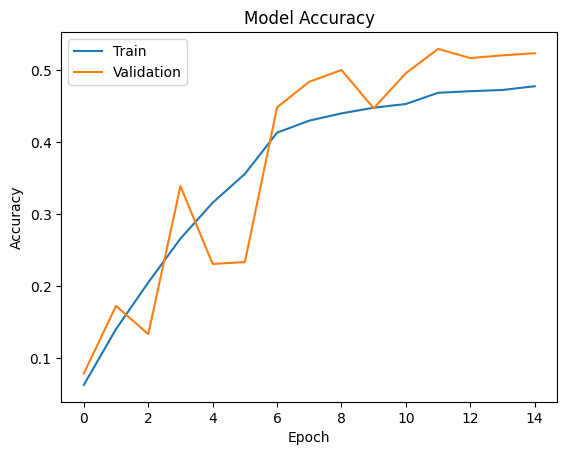

In [30]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()



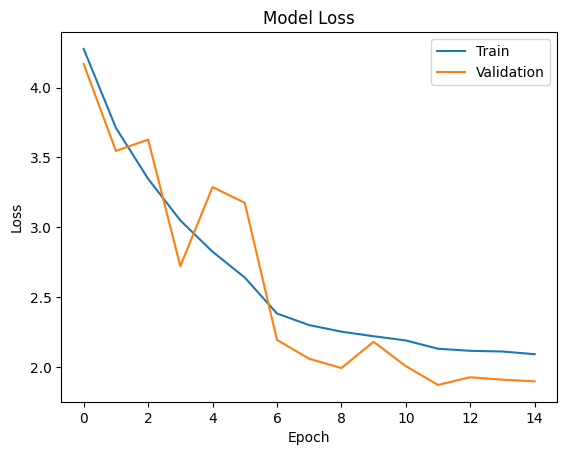

In [31]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

# Model 2

In [91]:
#train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, [32, 32]), y))
#test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, [32, 32]), y))

In [31]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models, Input
inputs = Input(shape=(224, 224, 3))

base_model = EfficientNetB0(
    include_top=False,
    input_shape=(224, 224, 3),
    weights='imagenet'
)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [32]:
base_model.trainable = False

In [33]:
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(101, activation='softmax')(x)

In [34]:
model = models.Model(inputs, outputs)

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [35]:
history = model.fit( train_ds,validation_data=test_ds,epochs=10, batch_size=64)

Epoch 1/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 149s 53ms/step - accuracy: 0.4024 - loss: 2.4633 - val_accuracy: 0.6677 - val_loss: 1.2180
Epoch 2/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 107s 45ms/step - accuracy: 0.5732 - loss: 1.6475 - val_accuracy: 0.6916 - val_loss: 1.1240
Epoch 3/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 108s 46ms/step - accuracy: 0.6020 - loss: 1.5275 - val_accuracy: 0.7027 - val_loss: 1.0844
Epoch 4/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 109s 46ms/step - accuracy: 0.6209 - loss: 1.4372 - val_accuracy: 0.7082 - val_loss: 1.0699
Epoch 5/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 109s 46ms/step - accuracy: 0.6395 - loss: 1.3567 - val_accuracy: 0.7086 - val_loss: 1.0635
Epoch 6/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 109s 46ms/step - accuracy: 0.6477 - loss: 1.3047 - val_accuracy: 0.7125 - val_loss: 1.0572
Epoch 7/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 109s 46ms/step - accuracy: 0.6604 - loss: 1.2536 - val_accuracy: 0.7121 - val_loss: 1.0631
Epoch 8/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 109s 46ms/step - accuracy: 

EfficientNetB4

In [32]:
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras import layers, models, Input, optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
inputs = Input(shape=(224, 224, 3))

base_model = EfficientNetB4(
    include_top=False,
    input_shape=(224, 224, 3),
    weights='imagenet'
)


In [33]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
])


In [34]:
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

In [35]:
x = data_augmentation(inputs)
x = base_model(x) 

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(101, activation='softmax')(x)

In [36]:
model = models.Model(inputs, outputs)

learning_rate = 0.1
optimizer = optimizers.Adam(learning_rate=learning_rate)

model.compile(
    optimizer="Adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)



In [38]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,  
    patience=2, 
    min_lr=1e-6,
    verbose=1 
)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1
)
history = model.fit(
    train_ds, 
    validation_data=test_ds, 
    epochs=11,
    callbacks=[lr_scheduler,early_stop] 
)

Epoch 1/11


E0000 00:00:1766262835.848753      47 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_5_1/efficientnetb4_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2368/2368 ━━━━━━━━━━━━━━━━━━━━ 743s 303ms/step - accuracy: 0.3959 - loss: 2.5722 - val_accuracy: 0.7321 - val_loss: 1.0102 - learning_rate: 0.0010
Epoch 2/11
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 710s 300ms/step - accuracy: 0.6182 - loss: 1.5205 - val_accuracy: 0.7613 - val_loss: 0.9071 - learning_rate: 0.0010
Epoch 3/11
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 711s 300ms/step - accuracy: 0.6725 - loss: 1.2960 - val_accuracy: 0.7754 - val_loss: 0.8808 - learning_rate: 0.0010
Epoch 4/11
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 712s 301ms/step - accuracy: 0.7053 - loss: 1.1491 - val_accuracy: 0.7911 - val_loss: 0.8131 - learning_rate: 0.0010
Epoch 5/11
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 712s 301ms/step - accuracy: 0.7346 - loss: 1.0280 - val_accuracy: 0.7948 - val_loss: 0.8294 - learning_rate: 0.0010
Epoch 6/11
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.7521 - loss: 0.9403
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 712s 301ms/step - accur

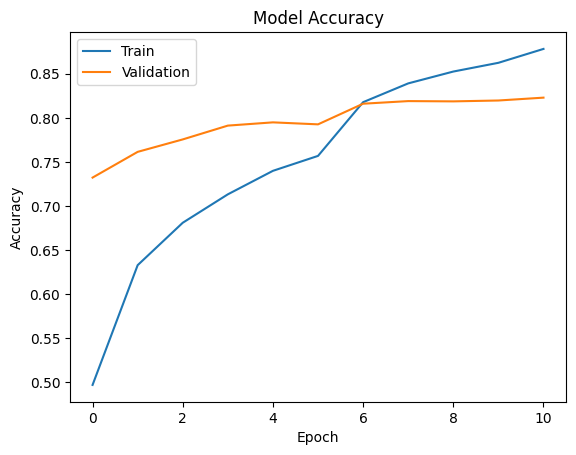

In [41]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()



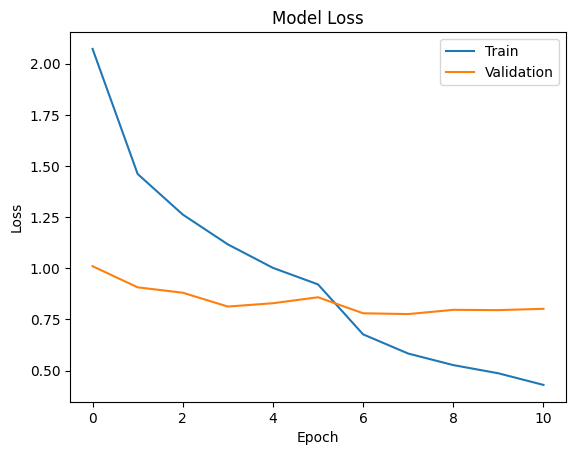

In [42]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

In [43]:
model.save("food101_custom_FINAL_51acc.keras")